In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [3]:
IMAGE_SIZE = 256  # height and width of the image.
BATCH_SIZE = 34
CHANNELS = 3  # 3 channels for RGB
EPOCHS = 100

MAX_DATASETS_TO_USE = 620

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    # r"dataset/plantvillage dataset/color/",
    r"/kaggle/input/plantvillage-dataset/color/",
    # r"dataset/potato/",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 54305 files belonging to 38 classes.


In [5]:
class_names = dataset.class_names
Total_classes_detected = len(class_names)
print(class_names, Total_classes_detected)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [6]:
original_dataset_size = len(dataset)
print(original_dataset_size)

1598


In [7]:
dataset = dataset.take(MAX_DATASETS_TO_USE)

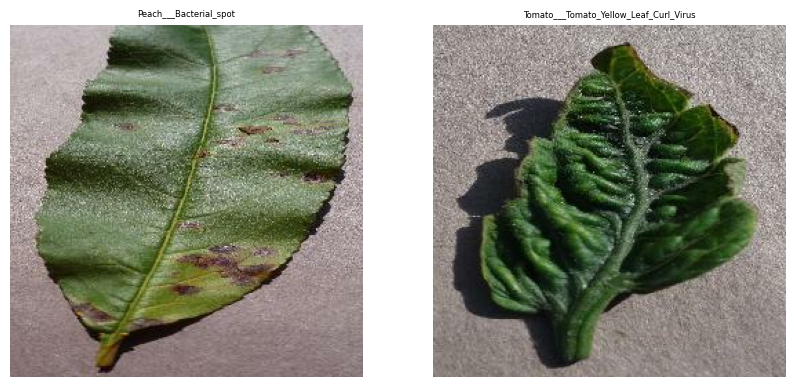

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, lable_batch in dataset.take(1):
    # print(image_batch.shape)
    # print(lable_batch.numpy())

    # print(image_batch[0].numpy().shape)
    for i in range(2):
        ax = plt.subplot(1, 2, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[lable_batch[i]], fontsize=6)
        plt.axis("off")


In [9]:
print(f"{int((MAX_DATASETS_TO_USE / original_dataset_size) * 100)}% dataset is used")

38% dataset is used


In [10]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)


    return train_ds, val_ds, test_ds



In [11]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)
print(len(train_ds), len(val_ds), len(test_ds))

496 62 62


Caching and **Prefetching**

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds   =   val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds  =  test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [15]:
n_classes = Total_classes_detected

model = models.Sequential([

    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),

    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),

    
    layers.Flatten(),

    layers.Dense(64, activation='relu'),

    layers.Dense(n_classes, activation='softmax'),
])

model.build()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,790 (370.27 KB)

 Trainable params: 94,790 (370.27 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    validation_data=val_ds
)

Epoch 1/100
496/496 ━━━━━━━━━━━━━━━━━━━━ 78s 57ms/step - accuracy: 0.1668 - loss: 3.1558 - val_accuracy: 0.3140 - val_loss: 2.4870
Epoch 2/100
496/496 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.3518 - loss: 2.2971 - val_accuracy: 0.4402 - val_loss: 1.9595
Epoch 3/100
496/496 ━━━━━━━━━━━━━━━━━━━━ 36s 56ms/step - accuracy: 0.4592 - loss: 1.8691 - val_accuracy: 0.4701 - val_loss: 1.9008
Epoch 4/100
496/496 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.5528 - loss: 1.5130 - val_accuracy: 0.5797 - val_loss: 1.4415
Epoch 5/100
496/496 ━━━━━━━━━━━━━━━━━━━━ 36s 56ms/step - accuracy: 0.6248 - loss: 1.2306 - val_accuracy: 0.6162 - val_loss: 1.2095
Epoch 6/100
496/496 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.6752 - loss: 1.0404 - val_accuracy: 0.6684 - val_loss: 1.0770
Epoch 7/100
496/496 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.7129 - loss: 0.9131 - val_accuracy: 0.7301 - val_loss: 0.8422
Epoch 8/100
496/496 ━━━━━━━━━━━━━━━━━━━━ 36s 56ms/step - accuracy: 0.7441 - loss: 0

In [18]:
scores = model.evaluate(test_ds)
print(scores)

62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9332 - loss: 0.2348
[0.20944447815418243, 0.9383301734924316]


In [19]:
history.history.keys()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


Text(0.5, 1.0, 'Training and Validation Loss')

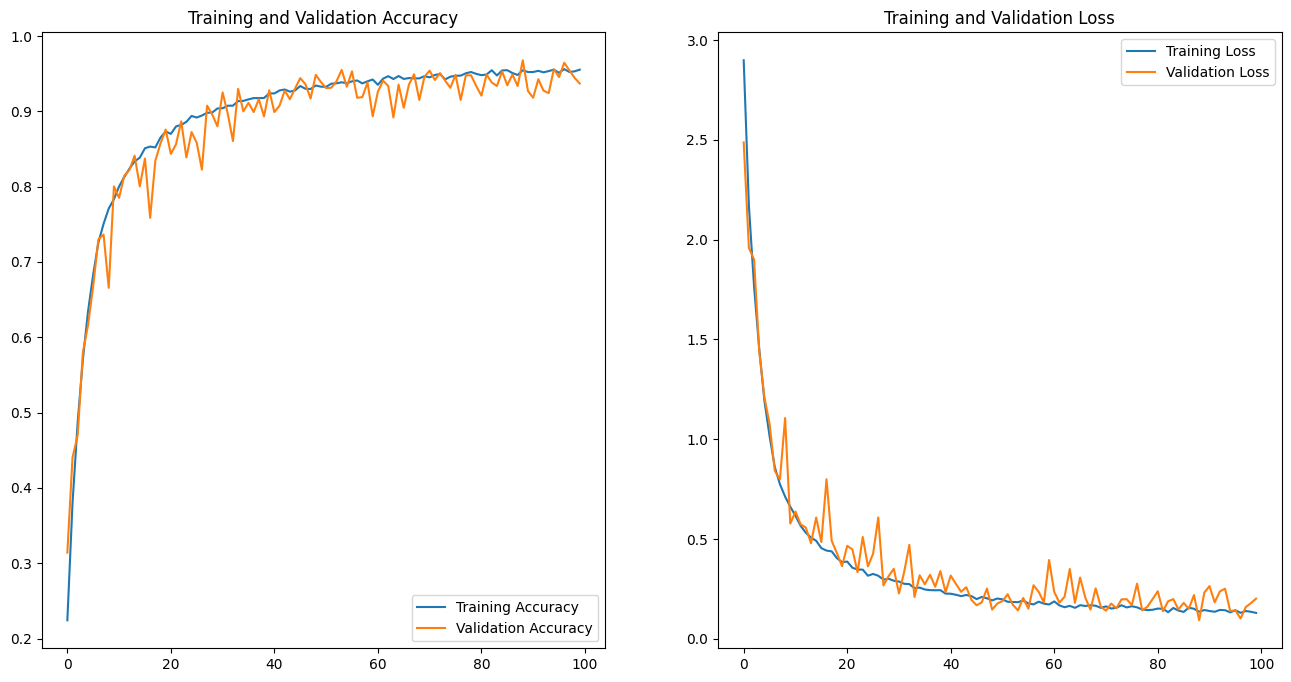

In [20]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

first image to predict
actual label: Grape___Esca_(Black_Measles)
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step
predicted label: Grape___Esca_(Black_Measles)


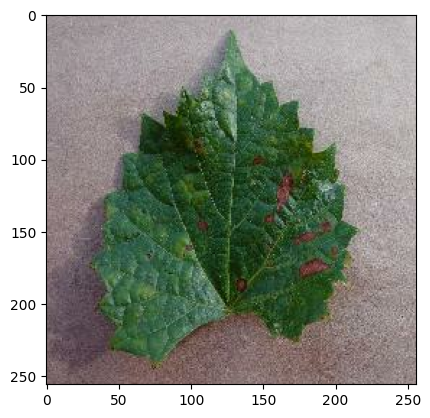

In [21]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [22]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)

    return predicted_class, confidence

In [1]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}, \n Confidence: {confidence}%", fontsize=8)

        plt.axis("off")

NameError: name 'plt' is not defined

# **Saving the model**

In [24]:
int(scores[1]*100)


93

In [25]:
model.save(f"final_31_8_24_acc-{str(int(scores[1]*100))}_loss-{str(int(scores[0]*100))}.h5")


TypeError: cannot pickle 'module' object

In [26]:
model.save(f"final_31_8_24_keras_acc-{str(int(scores[1]*100))}_loss-{str(int(scores[0]*100))}.keras")

In [ ]:
# !pip install pyyaml h5py  # Required to save models in HDF5 format
